In [ ]:
pip install transformers sentencepiece

In [ ]:
import pandas as pd
import numpy as np
from transformers import CamembertTokenizer, CamembertForSequenceClassification, TrainingArguments, Trainer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load the dataset
df = pd.read_pickle("data/manually_labelled_df.pkl")

In [ ]:
# Count the frequency of each label
label_counts = df['new_labels'].value_counts()
label_counts

new_labels
1    3417
0     602
Name: count, dtype: int64

In [ ]:
# Perform stratified sampling to maintain the label distribution
df, unseen_df = train_test_split(df, train_size=3500, stratify=df['new_labels'], random_state=42)
df.reset_index(drop=True, inplace=True)
unseen_df.to_pickle("data/unseen_df_2.pkl")

In [ ]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Creates list of texts and labels
text = df['tweet_clean0'].to_list()
labels = df['new_labels'].to_list()

In [ ]:
# Compute the maximum sequence length
max_length = 0
for sent in text:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_length = max(max_length, len(input_ids))

# You can add a buffer value for padding if needed
MAX_LEN = max_length + 10

In [ ]:
#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN,truncation=True) for sent in text]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.2)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Count the occurrences of 1s and 0s
counts = np.bincount(validation_labels)

# Calculate the percentage of 1s and 0s
total_count = len(validation_labels)
percentage_1 = (counts[1] / total_count) * 100
percentage_0 = (counts[0] / total_count) * 100

print(f"Percentage of 1s: {percentage_1:.2f}%")
print(f"Percentage of 0s: {percentage_0:.2f}%")

Percentage of 1s: 84.14%
Percentage of 0s: 15.86%


In [ ]:
validation_labels

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Defining constants
epochs = 10
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# Define the optimizerhttps://colab.research.google.com/drive/1t7P0GkycEe3C9IY2OpGGbE7j9YKHWlbv#scrollTo=7vfA_xHshq3I
optimizer = optim.AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Initialize lists to store true and predicted labels for the entire dataset
true_labels = []
pred_labels = []

# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# Lists to store results
results_list = []

# trange is a tqdm wrapper around the normal python range
for epoch in range(epochs):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # Calculate average training loss per epoch
    avg_train_loss = tr_loss / nb_tr_steps
    train_loss_set.append(avg_train_loss)  # Append average training loss to the list

    # Print average training loss per epoch
    print(f"Epoch {epoch+1}/{epochs}")
    print("Average Train loss: {}".format(avg_train_loss))

    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    eval_precision, eval_recall, eval_f1 = 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluation of the model
    model.eval()

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute predictions for F1, precision, and recall
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        true_labels.extend(labels_flat)
        pred_labels.extend(pred_flat)

        tmp_eval_accuracy = accuracy_score(labels_flat, pred_flat)
        tmp_eval_precision = precision_score(labels_flat, pred_flat, average=None, zero_division=0)
        tmp_eval_recall = recall_score(labels_flat, pred_flat, average=None, zero_division=0)
        tmp_eval_f1 = f1_score(labels_flat, pred_flat, average=None, zero_division=0)

        eval_accuracy += tmp_eval_accuracy
        eval_precision += tmp_eval_precision
        eval_recall += tmp_eval_recall
        eval_f1 += tmp_eval_f1
        nb_eval_steps += 1

    # Calculate average evaluation metrics per epoch
    eval_accuracy /= nb_eval_steps
    eval_precision /= nb_eval_steps
    eval_recall /= nb_eval_steps
    eval_f1 /= nb_eval_steps

    # Print evaluation metrics per epoch
    print("Validation Accuracy: {}".format(eval_accuracy))
    print("Validation Precision: {}".format(eval_precision))
    print("Validation Recall: {}".format(eval_recall))
    print("Validation F1-score: {}".format(eval_f1))

    # Append results to the list
    results_list.append({
        'Epoch': epoch + 1,
        'Train Loss': avg_train_loss,
        'Validation Accuracy': eval_accuracy,
        'Validation Precision': eval_precision,
        'Validation Recall': eval_recall,
        'Validation F1 Score': eval_f1
    })


# Calculate metrics for each class
class_accuracy = accuracy_score(true_labels, pred_labels)
class_precision = precision_score(true_labels, pred_labels, average=None)
class_recall = recall_score(true_labels, pred_labels, average=None)
class_f1 = f1_score(true_labels, pred_labels, average=None)

print("Class-wise Accuracy:", class_accuracy)
print("Class-wise Precision:", class_precision)
print("Class-wise Recall:", class_recall)
print("Class-wise F1-score:", class_f1)

Epoch 1/10
Average Train loss: 0.2806680596513408
Validation Accuracy: 0.9602272727272727
Validation Precision: [0.84204545 0.9863678 ]
Validation Recall: [0.89318182 0.96741128]
Validation F1-score: [0.85208251 0.97583181]
Epoch 2/10
Average Train loss: 0.1485726992679494
Validation Accuracy: 0.9559659090909091
Validation Precision: [0.86363636 0.96844614]
Validation Recall: [0.80454545 0.98041494]
Validation F1-score: [0.82036436 0.9735298 ]
Epoch 3/10
Average Train loss: 0.1201020610332489
Validation Accuracy: 0.9616477272727273
Validation Precision: [0.83365801 0.98973943]
Validation Recall: [0.90075758 0.96522029]
Validation F1-score: [0.85512266 0.97652168]
Epoch 4/10
Average Train loss: 0.08820060459098646
Validation Accuracy: 0.9573863636363636
Validation Precision: [0.86022727 0.97318572]
Validation Recall: [0.84128788 0.97694862]
Validation F1-score: [0.83834776 0.97429452]
Epoch 5/10
Average Train loss: 0.06194986261693495
Validation Accuracy: 0.9630681818181818
Validation P

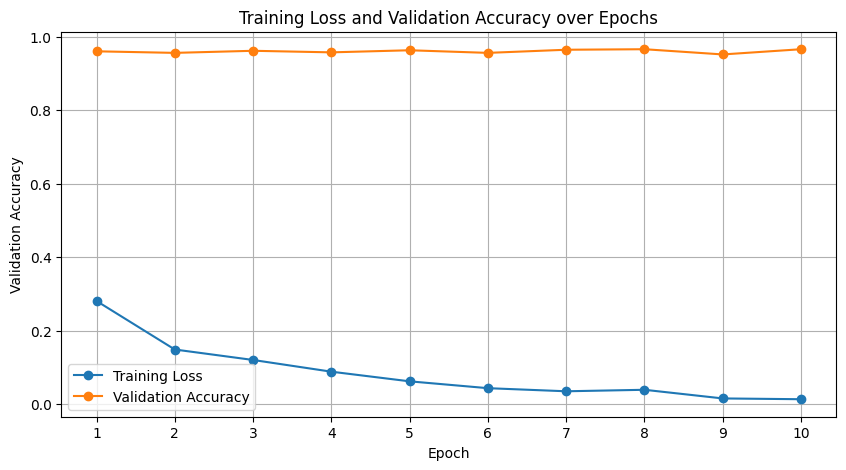

In [ ]:
# Extracting training loss and validation accuracy
train_loss = [result['Train Loss'] for result in results_list]
validation_accuracy = [result['Validation Accuracy'] for result in results_list]
epochs = range(1, len(results_list) + 1)

# Plotting
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss and Validation Accuracy over Epochs')
plt.xticks(epochs)

# Plot validation accuracy
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
plt.ylabel('Validation Accuracy')

# Save and show plot
plt.legend()
plt.grid(True)
plt.savefig("results/training_loss_and_validation_accuracy_plot.png", dpi=300)
plt.show()

In [ ]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Save the DataFrame to a CSV file
results_df.to_csv('results/validation_results_camembert_classifier.csv', index=False)

# Save the model
model.save_pretrained("models/camembert_model")

In [ ]:
cd drive/MyDrive/THESIS/Thesis project/french_antivax/clean_code_final

/content/drive/.shortcut-targets-by-id/1_N1bV_KKZIu0OTBH-PpAtD4IPLKDb4xq/THESIS/Thesis project/french_antivax/clean_code_final


In [ ]:
# Load the unseen data
df = pd.read_pickle("data/unseen_df_2.pkl")
df.reset_index(inplace=True, drop=True)

In [ ]:
# Count the occurrences of 1s and 0s
counts = np.bincount(df["new_labels"])

# Calculate the percentage of 1s and 0s
total_count = len(df["new_labels"])
percentage_1 = (counts[1] / total_count) * 100
percentage_0 = (counts[0] / total_count) * 100

print(f"Percentage of 1s: {percentage_1:.2f}%")
print(f"Percentage of 0s: {percentage_0:.2f}%")

Percentage of 1s: 84.97%
Percentage of 0s: 15.03%


In [ ]:
# Load the previously saved model
model = CamembertForSequenceClassification.from_pretrained("models/camembert_model", num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=True)

# Create lists of texts and labels
text = df['tweet_clean0'].to_list()
labels = df['new_labels'].to_list()

# Compute the maximum sequence length
max_length = 0
for sent in text:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_length = max(max_length, len(input_ids))

# You can add a buffer value for padding if needed
MAX_LEN = max_length + 10

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def preprocess_data(texts, labels):
    input_ids = []
    attention_masks = []

    for sent in texts:
        inputs = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=MAX_LEN,  # Set MAX_LEN as defined in your previous code
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)  # Convert labels to a tensor

    return input_ids, attention_masks, labels

In [ ]:
# Tokenize and preprocess the unseen data with labels
inputs, masks, labels = preprocess_data(text, labels)

# Create a TensorDataset with input IDs, masks, and labels
unseen_data = TensorDataset(inputs, masks, labels)

# Use a SequentialSampler for sampling the data
unseen_sampler = SequentialSampler(unseen_data)

# Create a DataLoader for the unseen data
unseen_dataloader = DataLoader(unseen_data, sampler=unseen_sampler, batch_size=batch_size)

In [ ]:
# Validation of the model
model.to(device)  # Move the model to the device

# Lists to store true labels and predicted labels for the entire dataset
true_labels = []
predictions = []

# Evaluate data for one epoch
# Iterate over batches of data
for batch in unseen_dataloader:
    batch = tuple(t.to(device) for t in batch)  # Move batch to the same device as the model
    input_ids, input_mask, labels = batch  # Extract labels from the batch
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(input_ids, attention_mask=input_mask)
        logits = outputs.logits

    true_labels.extend(labels.cpu().numpy())  # Extend the true_labels list
    predictions.extend(logits.argmax(dim=1).cpu().numpy())  # Extend the predictions

# Calculate and print metrics
true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')  # Specify the average parameter
recall = recall_score(true_labels, predictions, average='weighted')  # Specify the average parameter
f1 = f1_score(true_labels, predictions, average='weighted')  # Specify the average parameter

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9402697495183044
Precision: 0.9420717818508483
Recall: 0.9402697495183044
F1 Score: 0.9410269692068406


In [ ]:
# Calculate metrics for each class
precision_per_class = precision_score(true_labels, predictions, average=None)
recall_per_class = recall_score(true_labels, predictions, average=None)
f1_per_class = f1_score(true_labels, predictions, average=None)

# Compute weighted average
weighted_precision = precision_score(true_labels, predictions, average='weighted')
weighted_recall = recall_score(true_labels, predictions, average='weighted')
weighted_f1 = f1_score(true_labels, predictions, average='weighted')

# Compute macro average
macro_precision = precision_score(true_labels, predictions, average='macro')
macro_recall = recall_score(true_labels, predictions, average='macro')
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Create a dictionary to store metrics
metrics_dict = defaultdict(list)

# Add class-wise metrics to the dictionary
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    metrics_dict[f'Class {i}'].extend([precision, recall, f1])

# Add weighted average to the dictionary
metrics_dict['Weighted Average'].extend([weighted_precision, weighted_recall, weighted_f1])

# Add macro average to the dictionary
metrics_dict['Macro Average'].extend([macro_precision, macro_recall, macro_f1])

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Precision', 'Recall', 'F1 Score'])

# Display the DataFrame
print(metrics_df)

            Class 0   Class 1  Weighted Average  Macro Average
Precision  0.783133  0.970183          0.942072       0.876658
Recall     0.833333  0.959184          0.940270       0.896259
F1 Score   0.807453  0.964652          0.941027       0.886053


In [ ]:
# Save metrics to a CSV file
metrics_dict = {

    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv('results/metrics_camembert_unseen.csv', index=False)

misclassified_dict = {
    "text_temp": [],
    "true_labels_temp": [],
    "predictions_temps": []
}

misclassified = []

for i in range(len(true_labels)):
    if true_labels[i] != predictions[i]:
        misclassified.append((text[i], true_labels[i], predictions[i]))
        misclassified_dict["text_temp"].append(text[i])
        misclassified_dict["true_labels_temp"].append(true_labels[i])
        misclassified_dict["predictions_temps"].append(predictions[i])

for text, true_label, predicted_label in misclassified:
    print("Text:", text)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

# Save misclassified data to a CSV file
misclassified_df = pd.DataFrame(misclassified_dict)
misclassified_df.to_csv('results/camembert_misclassified.csv', index=False)


Text: Quand je vois les tweets sous le #DictatureSanitaire
True Label: 0
Predicted Label: 1

Text: L'ami du cousin de ma boulangère est mort suite à sa 2ème dose de vaccin.Il s'est fait renversé par un camion en sortant du vaccinodrome.Putain du vaccin. #antivax
True Label: 1
Predicted Label: 0

Text: Entre #Zemmour et sa guerre de #religion, #Pecresse qui se la joue Terminator à coup de #Karcher, #Macron l'emmerdeur qui prône la perte de citoyenneté pour les #antivax.Que j'entende plus dire que voter #Insoumis c'est impossible car ne saurai pas se tenir 😂
True Label: 1
Predicted Label: 0

Text: Peut être que si c’est #Biden qui leur dit ce sera plus audible #antivax
True Label: 1
Predicted Label: 0

Text: #Macron ha copiato e incollato:vergogna #NousSommesDesMillions #noobbligovaccinale
True Label: 0
Predicted Label: 1

Text: #DictatureSanitaireLe vaccin chinois fonctionne puisque tout le monde revit là bas
True Label: 1
Predicted Label: 0

Text: "On peut discuter de tout, sauf des ch

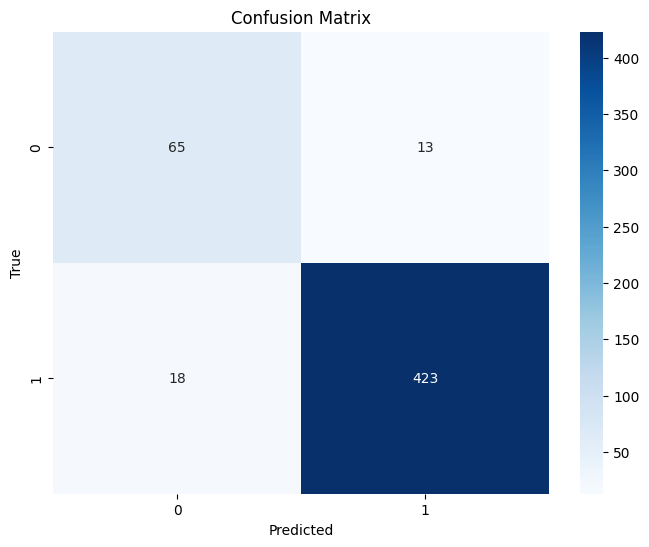

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Save confusion matrix to a CSV file
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['True 0', 'True 1'])
cm_df.to_csv('results/camembert_confusion_matrix.csv')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("results/confusion_matrix.png", dpi=300)
plt.show()